In [1]:
import pandas as pd
import numpy as np
from numpy import percentile

import matplotlib.pyplot as plt
from pylab import rcParams

rcParams['figure.figsize'] = 15, 5

import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats
from scipy.stats import shapiro

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.factorplots import interaction_plot

In [2]:
df = pd.read_csv("/Users/narihwang/Desktop/A:B TEST/A/B Testing examples: from easy to advanced/ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
# 중복된 행이 있는 확인
# 분석 왜곡, 모델 성능 저하, 효율성 문제를 줄이기 위해

# 데이터 프레임의 각 행이 중복 되는지 확인
dups = df.duplicated()
# 하나라도 중복된 행이 있으면 True, 없으면 False
print(dups.any())

False


In [5]:
# user_id 중복 확인 -> 중복된 user_id를 가진 행만 출력
# user_id 컬럼에서 중복된 값만 필터링 -> 중복된 행만 선택
df[df["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted
2656,698120,13:42.6,control,old_page,0
2893,773192,55:59.6,treatment,new_page,0
7500,899953,06:54.1,control,new_page,0
8036,790934,32:20.3,treatment,new_page,0
10218,633793,16:00.7,treatment,old_page,0
...,...,...,...,...,...
294309,787083,15:21.0,control,old_page,0
294328,641570,59:27.7,control,old_page,0
294331,689637,34:28.3,control,new_page,0
294355,744456,32:07.1,treatment,new_page,0


In [6]:
# A/B 테스트를 하기 위한 그룹 나누기
# 실험 그룹 langding_page가 old_page인 경우와
# 대조군은 landing_page가 new_page인 경우
df_mismatch = df[(df["group"]=="treatment")&(df["landing_page"]=="old_page")
                |(df["group"]=="control")&(df["landing_page"]=="new_page")]

# 중복된 값이나 NaN없이 필터링된 행의 수 
n_mismatch = df_mismatch.shape[0]

# 불일치하는 행의 수 출력
print(f"The number of mismatched rows : {n_mismatch} rows")

# 전체 데이터에서 불일치하는 행의 백분율 계산
print("Percent of mismatched rows : %.2f%%" % (n_mismatch/df.shape[0]*100))

The number of mismatched rows : 3893 rows
Percent of mismatched rows : 1.32%


mismatch 된 데이터 : 예상하거나 의도한 조건에 맞지 않는 데이터를 의미
특히, A/B 테스트에서는 각 그룹에 대해 특정 조건이나 설정이 지정된다.
만약 이러한 조건이 일치하지 않는 데이터를 발견했을 때 "mismatch data"라고 부른다.

두 개의 그룹 조건
1. 실험 그룹(treatment group)은 old_page를 봐야한다
2. 대조군(control group)은 new_page를 봐야한다

The number of mismatched rows : 3893 rows
-> 실험그룹의 조건과 대조군의 조건이 일치 하지 않는 데이터 행이 3893개 
-> user_id가 3895번 중복되어 있으며, 동시에 로딩한 것

Percent of mismatched rows : 1.32%


In [7]:
# 실험 그룹 : new_page
# 대조 그룹 : old_page
# df2 저장

df2 = df[(df["group"]=="treatment")&(df["landing_page"]=="new_page")
                |(df["group"]=="control")&(df["landing_page"]=="old_page")]

In [8]:
# df2 에서 중복된 user_id 찾기
df2[df2["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,55:59.6,treatment,new_page,0
294478,759899,20:29.0,treatment,new_page,0


In [9]:
df2[df2["user_id"]==773192]


,user_id,timestamp,group,landing_page,converted
1899,773192,37:58.8,treatment,new_page,0
2893,773192,55:59.6,treatment,new_page,0


In [10]:
# df2에서 user_id가 중복되는 행을 제거
# subset = "user_id" : 중복을 판단할 기준 열로 user_id로 지정
# inplace = treu : df2에 직접 변경사항 적용

df2.drop_duplicates(subset="user_id",inplace=True) 


In [11]:
# 중복 제거후 데이터 프레임의 크기 (290587개의 행, 5개의 열)
df2.shape


(290585, 5)

In [12]:
df_counts = pd.DataFrame({"Control_COUNT": df2[df2.group=="control"].converted.value_counts(),
              "Treatment_COUNT": df2[df2.group=="treatment"].converted.value_counts(),
              "Control_RATIO": df2[df2.group=="control"].converted.value_counts()/ len(df2[df2.group=="control"]),
              "Trement_RATIO": df2[df2.group=="treatment"].converted.value_counts() / len(df2[df2.group=="treatment"])})
df_counts

,Control_COUNT,Treatment_COUNT,Control_RATIO,Trement_RATIO
converted,,,,
0,127785,128047,0.879614,0.881193
1,17489,17264,0.120386,0.118807


df_counts 새로운 데이터프레임 생성
- Control_COUNT
    - df2에서 실험 그룹 (group == "control")만 선택
    - 실험 그룹 데이터의 converted 열에서 값들의 빈도수 계산
    - 대조군에서 각 conveted 값의 발생 빈도를 계산한 것

- Treatment_COUNT 
    - df2에서 대조군 (group == "treatment")만 선택
    - 대조군 그룹 데이터의 converted 열에서 값들의 빈도수 계산
    - treatment 그룹에서 각 converted 값의 발생 빈도를 계산한 것

- Control_Ratio
    - 대조군의 각 converted 값의 빈도수를 해당 그룹의 총 길이로 나누어 비율 계산
    - 즉, 대조군에서 각 converted 값이 나타날 확률을 계싼

- Treatment_Ratio
    - 실헙그룹의 각 converted 값의 빈도수를 해상 그룹의 총 길이로 나누어 비율 계산
    - 즉, 실험그룹에서 각 converted 값이 나타날 확률


변환율을 비교하는 이유
1. A/B TEST 결과
    - 두 그룹의 변환율을 비교하여 실험 결과의 차이를 평가
    - 빈도수와 비율을 계산함으로써 실험이 성공적으로 목표를 달성했는지 여부 파악

2. 비율을 통한 통계적 유의성
    - 두 그룹 간의 차이를 검정하는 통계적 검정을 진행할 수 있다.
    


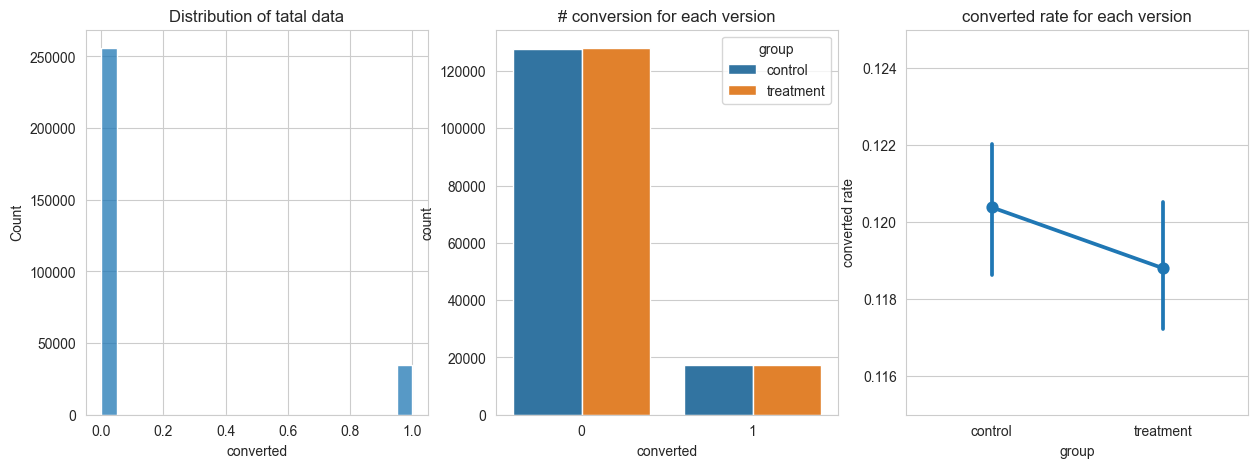

In [13]:
fig, axes = plt.subplots(1,3)

# 전체 데이터에서 전환 여부의 분포(0과 1의 빈도 차이)를 확인
sns.histplot(x="converted", data = df2, ax = axes[0])       # x축 : 전환율(0과 1), y축 : 해당 값 빈도
axes[0].set_title("Distribution of tatal data")

# 대조군과 실험군 각각에서 전환 성공 / 실패 빈도 비교
sns.countplot(x = 'converted', data = df2, hue = "group", ax = axes[1])     # x축 : 전환율 (0과 1), y축 : 각 값의 빈도
axes[1].set(title = "# conversion for each version", ylabel = "count")

# 대조군과 실험군의 평균 전환율 차이를 비교
sns.pointplot(x = 'group', y = 'converted', data = df2, ax = axes[2])       # x축 : 그룹, y축 : 그룹별 평균 전환율
axes[2].set_ylim([0.115, 0.125])
axes[2].set(title = 'converted rate for each version', ylabel = "converted rate")

plt.show()

# 그래프 해석
## 1.
- 대부분의 데이터가 converted = 0에 속하며, converted = 1의 데이터는 상대적으로 적습니다. -> 전환율이 낮다

## 2.
- 두 그룹의 데이터를 비교한다.
- 두 그룹 모두 converted = 0이 월등히 많습니다.
- converted = 1의 경우, 두 그룹 간 차이는 시각적의로 거의 보이지 않습니다. 전환율의 차이가 미미하다

## 3.
- 두 그룹의 전환율을 비교한 그래프
- control그룹이 treatment보다 약간 더 높은 전환율을 보인다
- 오차 막대가 겹치고 있어, 두 그룹 간 전환율 차이가 통계적으로 유의미하지 않아 보인다.

# 새로운 제안
- 이산형 변수(converted)와 대규모 샘플 데이터(데이터프레임의 모든 데이터)를 기반으로 카이제곱 검정이 적합합니다.
    - 카이제곱 검정이란?
        - 범주형 데이터의 관측 빈도와 기대빈도를 비교한다
        - converted는 범주형 변수(0과 1의 값), 두 그룹(control, treatment)간 분포 차이를 평가해야 하기에 검정 제곱이 적합

- 새로운 버전(treatment)이 기존 버전보다 전환율이 낮아 보이지만, 두 그룹 간 차이는 유의미하지 않을 가능성이 있습니다.
- 가설 검정을 통해 차이가 통계적으로 유의미한지 확인해야한다

In [14]:
table = df_counts.iloc[:,0:2].to_numpy()
table

array([[127785, 128047],
       [ 17489,  17264]])

In [15]:
stat, p, dof, expected = stats.chi2_contingency(table)
print("fredoom of degree=%d"% dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1-prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')


fredoom of degree=1
[[127899.7125385 127932.2874615]
 [ 17374.2874615  17378.7125385]]
probability=0.950, critical=3.841, stat=1.705
Independent (fail to reject H0)
significance=0.050, p=0.192
Independent (fail to reject H0)


# 코드 해석
stat, p, dof, expected = stats.chi2_contingency(table)
-> stats.chi2_contingency(table) 함수는 2차원 배열에 대해 카이제곱 독립성 검정을 수행
-> stat : 카이제곱 검정 통계량
-> p : p-value
-> dof : 자유도
-> expected : 기대 빈도 배열

prob = 0.95
-> 신뢰구간 설정 (95%)
critical = stats.chi2.ppf(prob, dof)
-> 자유도에 해당하는 카이제곱 분포의 95번째 백분위수를 계산

if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
-> stat(검정 통계량)의 절대값이 critical(임계값) 보다 크거나 같으면, 귀무가설을 기각하고 두 변수 간에 의존성이 있다고 결론
-> 그렇지 않다면, 두 변수는 독립적이다(상관관계 없음)


# 출력값 해석
freedom of degree = 1 자유도가 1이다.
카이제곱 검정에서 자유도 = (행의 수 -1) * (열의 수 -1)

probability=0.950, critical=3.841, stat=1.705
신뢰수준 : 95%, 임계값 : 3.841, 검정 통계량 : 1.705
1.705 < 3.841이므로 임계값 기준에서는 귀무가설(H0)을 기각할 수 없음을 의미합니다.

Independent (fail to reject H0)
검정 통계량(1.705)이 임계값(3.841)보다 작으므로, 두 변수 사이에 통계적으로 유의한 연관성이 없다고 해석됩니다.

significance=0.050, p=0.192
유의수준 α는 1-0.95 = 0.05로 설정되었습니다
p-value는 0.192로 계산되었는데, 이는 관측된 통계량이 귀무가설 하에서 나타날 확률이 약 19.2%임을 의미합니다.

In [18]:
odd_ratio, p_value = stats.fisher_exact(table, alternative="two-sided")
print("odd ratio is : " + str(odd_ratio))
print("p_value is : " + str(p_value))
if p_value <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

odd ratio is : 0.9851149705891606
p_value is : 0.19047607131914918
Independent (fail to reject H0)


In [19]:
def AB_testing(dataframe, group, metric):
    
    # Split groups
    group_c = dataframe[dataframe[group] == "control"][metric]
    group_t = dataframe[dataframe[group] == "treatment"][metric]
    
    size = dataframe.shape[0]  
    table = pd.DataFrame({"C_COUNT": group_c.value_counts(),
              "T_COUNT": group_t.value_counts()}).to_numpy()
    
    if size < 1000:
        # Fisher Exact Test
        odd_ratio, p_value = stats.fisher_exact(table, alternative="two-sided")
    else:
        # Pearson Chi Square Test
        stat, p_value, dof, expected = stats.chi2_contingency(table)
    # Result
    temp = pd.DataFrame({
        "Test":[size<1000],
        "P_value":[p_value],
        "AB Hypothesis":[p_value < 0.05], 
    })
    temp["Test"] = np.where(temp["Test"]==True, "Fisher Exact Test", "Chi Square Test")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    return temp
   
# Apply A/B Testing
AB_testing(dataframe=df2, group = "group", metric = "converted")

,Test,P_value,AB Hypothesis,Comment
0,Chi Square Test,0.19159,Fail to Reject H0,A/B groups are similar!


AB_testing 함수를 생성한다.
dataframe, group, metric 세 개의 인자를 받는다. (dataframe : 분석에 사용할 데이터 프레임, group : 그룹을 구분하는 컬럼, metric : 비교할 지표컬럼(converted))

group_c: "control" 그룹의 metric 값들
group_t: "treatment" 그룹의 metric 값들

table = pd.DataFrame({"C_COUNT": group_c.value_counts(),
              "T_COUNT": group_t.value_counts()}).to_numpy()
- value_counts()로 metric의 값들을 count
- 각 그룹의 metric 값들을 count하여 2x2 배열로 만든다

if size < 1000:
    # Fisher Exact Test
    odd_ratio, p_value = stats.fisher_exact(table, alternative="two-sided")
else:
    # Pearson Chi Square Test
    stat, p_value, dof, expected = stats.chi2_contingency(table)
- 샘플크기가 1000개 미만일 경우 
    - stats.fisher.exact 정확 검정을 사용 (작은 표본이나 셀의 기대 빈도가 낮은 경우 적합)
- 샘플크기가 1000개 이상인 경우
    - stats.chi2_contingency 피어슨의 카이제곱 검정을 사용 (대규모 표본에 대해 범주형 데이터 간의 독립석을 평가할 때 일반적으로 사용)

